<a href="https://colab.research.google.com/github/alejo14171/EM-PIC-Code-UTP/blob/main/EM_PIC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Parámetros e Imports

In [108]:
import math
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from numpy import random
import pandas as pd
import random
import sys
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import BoundaryNorm
from matplotlib.ticker import MaxNLocator

import os
import imageio

# PARAMETROS DE LA MALLA SIN NORMALIZAR
Nx            = 64
Ny            = 64
dx            = 1.0
dy            = 1.0
dt            = 0.5
Npart_cell    = 1 # Número inicial de PARTÍCULAS en cada celda
beta_e        = 1 # magnetic electron rest enegy ratio
beta_i        = 1 # magnetic ion rest enegy ratio

# PARÁMETROS DEL PLASMA (Gaussian cgs units)
m_e           = 1 #masa del electrón
c             = 1 #velocidad de la luz
q_0           = 1 #carga eléctrica de referencia
kb            = 1 #Constante de Boltzmann 
n0            = 1 #Densidad de electrones
eps           = 1 #permitividad del vacio (Faraday/m) 
mi_me         = 100 #razón de masa ion/ele
m_i           = mi_me * m_e #masa iones
q_e           = -1*q_0 #carga del electrón
q_i           = 1*q_0 #carga del ión (protón)
courant_num   = (c*dt)/dx #número de Courant

B_0 = 1#m_e*c*w_0/q_e
E_0 = B_0/c#m_e*(w_0**2)*x_0/q_e


       
w_pe          = np.sqrt((n0*q_0**2)/m_e) #Frecuencia de los electrones en el plasma
w_pi          = np.sqrt((n0*q_0**2)/m_i) #Frecuencia de los iones en el plasma 
w_ce          = q_0*B_0/m_e*c #electron gyrofrequency
w_ci          = q_0*B_0/m_i*c #ion gyrofrequency
       
Ti            = (B_0**2 * beta_i)/(2*n0*kb) #Temperatura de los iones (K)
Te            = (B_0**2 * beta_e)/(2*n0*kb) #Temperatura de los electrones (K)
vth_e         = (kb*Te/m_e)**0.5 # Velocidad térmica electrones
vth_i         = (kb*Ti/m_i)**0.5 # Velocidad térmica iones
     
lambda_d      = ((kb*Te)/(n0*q_0**2))**0.5 # Longitud de Debye
r_e           = vth_e/w_ce # Giroradio del electrón
r_i           = vth_i/w_ci # Giroradio del ion
d_e           = c/w_pe # distancia inercial del electrón
d_i           = c/w_pi # distancia inercial del protón

# Parámetros de renomalización
w_0           = w_pe
x_0           = lambda_d
v_0           = x_0*w_0

# Renormalización
wci          = w_ci/w_0
wce          = w_ce/w_0
wpi          = w_pi/w_0
wpe          = w_pe/w_0

vthi         = vth_i/v_0
vthe         = vth_e/v_0

E_0 = m_e*(w_0**2)*x_0/q_e

di           = d_i/x_0
de           = d_e/x_0
ri           = r_i/x_0
re           = r_e/x_0
lambdad      = lambda_d/x_0

w0           = w_0/w_0
x0           = x_0/x_0
v0           = v_0/v_0

print('escalas espaciales: ',lambdad,re,de,ri,di) #imprimir escalas espaciales 
print('escalas temporales: ',wpe,wce,wpi,wci)#imprimir escalas temporales 
print('velocidades: ',vthe,vthi)#imprimir escalas en velocidad

# PARAMETROS DE LA MALLA
Xmin          = 0
Xmax          = Nx*x0 #<----Normalizado
Ymin          = 0
Ymax          = Ny*x0 #<----Normalizado
Ly            = Ymax-Ymin
Lx            = Xmax-Xmin

# Parámetros de las partículas en la malla

Np          = Npart_cell*Nx*Ny # Número total de electrones
partweight    = 1 # Peso de cada partícula por celda

Af = 0#Nx*Ny/Np

# Parámetros del ciclo (iteraciones)
n_iteraciones = 50
n_out         = 5 #int(0.5/dt) # Esto es cada dos iteraciones hace outputs
n_check       = 1 # Cada cuanto se guarda informacion
t_final       = n_iteraciones*dt

# Pendiente
dim           = 3

# Para la distribución gaussiana, qué poner para que quede solamente la vth
mu            = 1
sigma         = 1
Vth           = mu

escalas espaciales:  1.0 1.0 1.414213562373095 9.999999999999998 14.14213562373095
escalas temporales:  1.0 1.0 0.1 0.01
velocidades:  1.0 0.09999999999999999


# Funciones

## Graficos

In [143]:
def graficar_particula(especie, i,typecl, it):
#  fig, ax = plt.subplots()
#  plt.title("Trayectoria de la partícula")
#  plt.xlabel("x")
#  plt.ylabel("y")
  # Particle Trajectory
  lp = [] #np.array([])
  lv = [] #np.array([])
  ii= i #particular N
  print(ii)

  for i in range(0,it,n_check):
    file_name = especie + str(i) +'.pkl'
    print(file_name)
    df = pd.read_pickle(file_name)
    print(df.iloc[ii,[0,1,2]])
    # input()
    tmp1 = np.array(df.iloc[ii,[0,1,2]])
    tmp2 = np.array(df.iloc[ii,[3,4,5]])
    # print(lp)
    # input()
    lp.append(tmp1) #lp = np.append(lp, tmp1, axis=i) #
    lv.append(tmp2) #lv = np.append(lv, tmp2, axis=i)
  lp = np.array(lp)
  lv = np.array(lv)

  for i in range(len(lp)):
    plt.plot(lp[i,0], lp[i,1],typecl)
    plt.xlim([-1, 65])
    plt.ylim([-1, 65])
    # plt.plot()

  # i = 10
  # file_name = especie + str(i) +'.pkl'
  # print(file_name)
  # df = pd.read_pickle(file_name)
  # x_act = np.array(df.iloc[:,[0,1,2]])
  # v_act = np.array(df.iloc[:,[3,4,5]])  

  # v_new = velocity(x_act,v_act,ex,ey,ez,bx,by,bz,dt, q_e, m_e)
  # x_new,x_BC = position(x_act,v_new,x_new,x_BC)
  # jx,jy = zig_zag(x_act,x_new,x_BC,jx,jy,partweight)
  # jx
  # jy

  # plt.figure(13);plt.clf()

  # plt.subplot(1,2,1)
  # plt.rcParams['figure.figsize'] = [14, 6]
  # plt.rcParams['figure.dpi'] = 50 # 200 e.g. is really fine, but slower
  # plt.title("Densidad de corriente en x")
  # plt.xlabel("x")
  # plt.ylabel("y")
  # plt.imshow(jx[:,:],extent=[Xmin,Xmax,Ymin,Ymax],aspect='auto');plt.colorbar()

  # plt.subplot(1,2,2)
  # plt.title("Densidad de corriente en y")
  # plt.xlabel("x")
  # plt.ylabel("y")
  # plt.imshow(jy[:,:],extent=[Xmin,Xmax,Ymin,Ymax],aspect='auto');plt.colorbar()

  # # fig.savefig('my_figure.png')

## FDTD

### FDTD_Halftime
Cambio en la normalización, las igualdades en las condiciones de frontera no se normalizan, porque a fin de cuentas hacemos unos nodos iguales a otros que ya están normalizados! Sería normalizar doble.

In [110]:
def FDTD_halftime(ex,ey,ez,bx,by,bz,dt_tmp):
  for i in range(Nx+1):
      for j in range(1,Ny+1):
          bx[i,j] = bx[i,j] - ((dt_tmp/dy)*(ez[i,j]-ez[i,j-1])) 

  #Condiciones de frontera Bx: Periodicidad
  for i in range(Nx+1):
      bx[i,0] = bx[i,Ny]

  for i in range(1,Nx+1):
      for i in range(Ny+1):
          by[i,j] = by[i,j] + ((dt_tmp/dx)*((ez[i,j]-ez[i-1,j]))) 

  #Condiciones de frontera By: Periodicidad
  for j in range(Ny+1):
      by[0,j] = by[Nx,j]

  for i in range(Nx):
      for j in range(Ny):
          bz[i,j]= bz[i,j] + ( ((dt_tmp/dy)*((ex[i,j+1]-ex[i,j]))) -
                              ((dt_tmp/dx)*(ey[i+1,j]-ey[i,j])) ) 
  
  #Condiciones de frontera Bz: Periodicidad
  bz[Nx,0]=bz[0,0] #Esquina
  for i in range(Nx+1):
      bz[i,Ny]=bz[i,0]
  for j in range(Ny+1):
      bz[Nx,j]=bz[0,j]

  return bx,by,bz

### FDTD

In [111]:
def FDTD(ex, ey, ez, bx,by, bz, Jx, Jy, Jz,
         ex_copy, ey_copy, ez_copy, bx_copy, by_copy, bz_copy,):

  # Parámetros de normalización
  

  #Evolución del campo BX,BY Y BZ ----> dt
  #Evolución de Bx,By,Bz ---> dt
  
  # ¿Si las copias de los campos se crean dentro de la función, para qué los
  # mandan como argumentos de la función?
  for i in range(Nx+1):
    for j in range(1,Ny+1):
      ex_copy[i,j], ey_copy[i,j], ez_copy[i,j] = ex[i,j], ey[i,j], ez[i,j]
      bx_copy[i,j], by_copy[i,j], bz_copy[i,j] = bx[i,j], by[i,j], bz[i,j]

  for i in range(Nx+1):
      for j in range(1,Ny+1):
          bx[i,j] = bx[i,j] - ((dt/dy)*(ez[i,j]-ez[i,j-1])) #Normalizado
  #Condiciones de frontera Bx: Periodicidad
  for i in range(Nx+1):
      bx[i,0] = bx[i,Ny]

  for i in range(1,Nx+1):
      for j in range(Ny+1):
          by[i,j] = by[i,j] + ((dt/dx)*((ez[i,j]-ez[i-1,j]))) # Normalizado
  #Condiciones de frontera By: Periodicidad
  for j in range(Ny+1):
      by[0,j] = by[Nx,j]

  for i in range(Nx):
      for j in range(Ny):
          bz[i,j] = bz[i,j] + ( ((dt/dy)*((ex[i,j+1]-ex[i,j]))) 
          - ((dt/dx)*(ey[i+1,j]-ey[i,j])) ) #Normalizado

  #Condiciones de frontera Bz: Periodicidad
  #Esquina
  bz[Nx,0] = bz[0,0]
  for i in range(Nx+1):
      bz[i,Ny] = bz[i,0]
  for j in range(Ny+1):
      bz[Nx,j] = bz[0,j]

  #Evolución de Ex,Ey,Ez ------> dt

  # Campo E en x
  for i in range(Nx+1):
      for j in range(1,Ny+1):
          ex[i,j] = ex[i,j] + ((dt/dy)*(bz[i,j]-bz[i,j-1])) - Af*Jx[i,j]*dt
  
  #Condiciones de frontera Ex: Periodicidad
  for i in range(Nx+1):
      ex[i,0] = ex[i,Ny]

  # Campo E en y
  for i in range(1,Nx+1):
      for j in range(Ny+1):
          ey[i,j] = ey[i,j] - ((dt/dx)*((bz[i,j]-bz[i-1,j]))) - Af*Jy[i,j]*dt

  #Condiciones de frontera Ey: Periodicidad
  for j in range(Ny+1):
      ey[0,j] = ey[Nx,j]

  # Campo E en z
  for i in range(Nx):
      for j in range(Ny):
          ez[i,j] = ez[i,j] - ( ((dt/dy)*((bx[i,j+1]-bx[i,j]))) - Af*Jz[i,j]*dt
          - ((dt/dx)*(by[i+1,j]-by[i,j])) )

  #Condiciones de frontera Ez: Periodicidad
  ez[Nx,0] = ez[0,0] #Esquina
  for i in range(Nx+1):
      ez[i,Ny] = ez[i,0]
  for j in range(Ny+1):
      ez[Nx,j] = ez[0,j]

  # Esto hace un promedio del campo B^{n-1/2} y B^{n+1/2}  
  for i in range(Nx+1):
      for j in range(Ny+1):
        bx_copy[i,j] = 0.5*(bx_copy[i,j]+bx[i,j])
        by_copy[i,j] = 0.5*(by_copy[i,j]+by[i,j])
        bz_copy[i,j] = 0.5*(bz_copy[i,j]+bz[i,j])

  return ex, ey, ez, bx, by, bz, ex_copy, ey_copy, ez_copy, bx_copy, by_copy, bz_copy

### Divergence

In [112]:
def divFt(fx_tmp,fy_tmp,fz_tmp,divF):
  divF = np.zeros([Nx+1,Ny+1])
  for ii in range(1,Nx+1):
    for jj in range(1,Ny+1):
      #print(i,j)
      divF[ii,jj] = (fx_tmp[ii,jj] - fx_tmp[ii-1,jj]) + (fy_tmp[ii,jj] - fy_tmp[ii,jj-1])
  
  # print(np.sqrt(np.mean(divF**2)))

  return divF

In [113]:
def densidad_carga2(fx_tmp,fy_tmp,fz_tmp,densidad):
  densidad = np.zeros([Nx+1,Ny+1])
  for ii in range(1,Nx+1):
    #print(i,j)
    densidad[ii,jj] = (fx_tmp[ii,jj] - fx_tmp[ii-1,jj]) + (fy_tmp[ii,jj] - fy_tmp[ii,jj-1])
  
  print(np.sqrt(np.mean(densidad**2)))

  return densidad

### Interc&Nodes Functions

In [114]:
def interc_to_nodes(ex_copy,ey_copy,ez_copy,
                    bx_copy,by_copy,bz_copy,
                    ex_nodes, ey_nodes, ez_nodes,
                    bx_nodes, by_nodes, bz_nodes):
  
  for i in range(Nx+1):
    for j in range(Ny):
      ex_nodes[i,j]=0.5*(ex_copy[i,j]+ex_copy[i,j+1])
      bx_nodes[i,j]=0.5*(bx_copy[i,j]+bx_copy[i,j+1])

  for i in range(Nx+1):
    ex_nodes[i,0]=ex_copy[i,Ny]
    bx_nodes[i,0]=bx_copy[i,Ny]

  for i in range(Nx):
    for j in range(Ny+1):
      ey_nodes[i,j]=0.5*(ey_copy[i,j]+ey_copy[i+1,j])
      by_nodes[i,j]=0.5*(by_copy[i,j]+by_copy[i+1,j])

  for j in range(Ny+1):
    ey_nodes[0,j]=ex_copy[Nx,j]
    by_nodes[0,j]=bx_copy[Nx,j]

  ez_nodes, bz_nodes =  ez_copy,bz_copy

  return ex_nodes, ey_nodes, ez_nodes, bx_nodes, by_nodes, bz_nodes

# #lleva los valores de los campos en los nodes(nx_1,ny+1) a los centros  (nx,ny)
# def nodes_to_c(xgc_ex,xgc_ey,xgc_ez,xgc_bx,xgc_by,xgc_bz,bx,by,ex,ey,bz,ez):
#   for i in range(Nx):
#     for j in range(Ny):
#       xcg_bx=0.25*(bx[i,j]+bx[i+1,j]+bx[i,i+1]+bx[i+1,j+1])
#       xcg_ex=0.25*(ex[i,j]+ex[i+1,j]+ex[i,i+1]+ex[i+1,j+1])
#       xcg_ey=0.25*(ey[i,j]+ey[i+1,j]+ey[i,i+1]+ey[i+1,j+1])
#       xcg_by=0.25*(by[i,j]+by[i+1,j]+by[i,i+1]+by[i+1,j+1])
#       xcg_bx=0.25*(bx[i,j]+bx[i+1,j]+bx[i,i+1]+bx[i+1,j+1])
#       xcg_ez=0.25*(ez[i,j]+ez[i+1,j]+ez[i,i+1]+ez[i+1,j+1])
#       xcg_bz=bz[i,j]


# #Lleva los valores de los campos en los centros (nx,ny) a los nodes nodos
# def c_to_nodes(xcg_ex, xcg_ey, xcg_ez, xcg_bx,xcg_by,xcg_bz,bx,by,ex,ey,bz,ez):
#   for i in range(1,Nx):
#     for j in range(1,Ny):
#       ex[i,j]=0.25*(xgc_ex[i-1,j-1]+xgc_ex[i,j-1]+xgc_ex[i-1,j]+xgc_ex[i,j])
#       bx[i,j]=0.25*(xgc_bx[i-1,j-1]+xgc_bx[i,j-1]+xgc_bx[i-1,j]+xgc_bx[i,j])
#       by[i,j]=0.25*(xgc_by[i-1,j-1]+xgc_by[i,j-1]+xgc_by[i-1,j]+xgc_by[i,j])
#       ey[i,j]=0.25*(xgc_ey[i-1,j-1]+xgc_ey[i,j-1]+xgc_ey[i-1,j]+xgc_ey[i,j])
#       ez[i,j]=0.25*(xgc_ez[i-1,j-1]+xgc_ez[i,j-1]+xgc_ez[i-1,j]+xgc_ez[i,j])
    
#   #for Ez 2D setup
#   for i in range(1,Nx):
#     for j in range(1,Ny):
#       bz[i,j]=xgc_bz[i-1,j-1]

#   for i in range(Nx):
#     ex[i,Ny]=ex[i,0]
#     bx[i,Ny]=bx[i,0]
#     ey[i,Ny]=ey[i,0]
#     by[i,Ny]=by[i,0]
#     ez[i,Ny]=ez[i,0]

#   for j in range(Ny):
#     ex[Nx,j]=ex[0,j]
#     bx[Nx,j]=bx[0,j]
#     ey[Nx,j]=ey[0,j]
#     by[Nx,j]=by[0,j]
#     ez[Nx,j]=ez[0,j]

#   for i in range(Nx+1):
#     bz[i,0]=bz[i,Ny]

#   for j in range(Ny+1):
#     bz[0,j]=bz[Nx,j]

#   #Esquina
#   bz[0,0]=bz[Nx,Ny]


#   for i in range(Nx):
#     for j in range(Ny):
#       bx_copy[i,j]=bx[i,j]
#       by_copy[i,j]=by[i,j]
#       bz_copy[i,j]=bz[i,j]
#       ex_copy[i,j]=ex[i,j]
#       by_copy[i,j]=ey[i,j]
#       ez_copy[i,j]=ez[i,j]

  
# def nodes_to_inter(ICx,ICy,bx_copy,by_copy,bz_copy,ex_copy,ey_copy,ez_copy,ex,ey,ez,bx,by,bz):
#   for i in range(Nx):
#     for j in range(Ny):
#       bx_copy[i,j]=bx[i,j]
#       by_copy[i,j]=by[i,j]
#       bz_copy[i,j]=bz[i,j]
#       ex_copy[i,j]=ex[i,j]
#       by_copy[i,j]=ey[i,j]
#       ez_copy[i,j]=ez[i,j]

#   for i in range(Nx+1):
#     for j in range(Ny+1):
#       ey_copy[i,j]=0.5*(ey[i,j]+ey[i-1,j])
#       by_copy[i,j]=0.5*(by[i,j]+by[i-1,j])
#       ICx[i,j]=0.5*(ICx[i,j]+ICx[i,j-1])

#   #Condiciones de frontera

#   for j in range(Ny+1):
#     ey[0,j]=ey[Nx,0]
#     by[0,j]=by[Nx,0]
#     ICy[0,j]=ICy[Nx,0]

#     for i in range(Nx+1):
#       for j in range(Ny+1):
#         ex_copy[i,j]=0.5*(ex[i,j]+ex[i-1,j])
#         bx_copy[i,j]=0.5*(bx[i,j]+bx[i-1,j])
#         ICy[i,j]=0.5*(ICy[i,j]+ICy[i,j-1])

#     for i in range(Nx+1):
#       ex[i,0]=ey[i,Ny]
#       bx[i,0]=by[i,Ny]
#       ICx[i,0]=ICx[i,Ny]

## PIC functions

### Velocity

In [115]:
def velocity(x_act,v_act,ex,ey,ez,bx,by,bz,dt_tmp, q_s, m_s, number_particles):
    for j in range(Np):
        # Renombro posición y velocidades
        x0, y0, z0 = x_act[j, 0], x_act[j, 1], x_act[j, 2]
        ux0, uy0, uz0 = v_act[j, 0], v_act[j, 1], v_act[j, 2]
        # Interpolación: found the closest node indexes according to particle position
        ileft, iright, hxleft, jdown, jup, hydown = interpolation(x0, y0)
        # Obtener campos tiempo n
        Ex, Ey, Ez, Bx, By, Bz = get_fields_nodes(ex, ey, ez, bx, by, bz, ileft, iright, hxleft, jdown, jup, hydown)
        # BorisA
        v_new[j, 0],v_new[j, 1],v_new[j, 2] = BorisA(Ex, Ey, Ez, Bx, By, Bz, ux0, uy0, uz0, q_s, m_s, dt_tmp)
    return v_new

### Position

In [116]:
def position(x_act,v_new, x_new, x_BC):
 

  for j in range(Np):
      x0, y0, z0 = x_act[j, 0], x_act[j, 1], x_act[j, 2]
      u_finalx, u_finaly, u_finalz = v_new[j, 0], v_new[j, 1], v_new[j, 2]
      x1, xBC1, x2, xBC2 , x3, xBC3 = leapfrog(x0, y0, z0,
                                               u_finalx, u_finaly, u_finalz)
      x_new[j, 0] = x1
      x_new[j, 1] = x2
      x_new[j, 2] = x3
      x_BC[j, 0] = xBC1
      x_BC[j, 1] = xBC2
      x_BC[j, 2] = xBC3
    
  return x_new, x_BC

### Energy

In [117]:
def energy(v_new):
    energia_cinetica = 0
    for j in range(Np):
        # Energía
        energia_cinetica = energia_cinetica + 0.5*m_e*(v_new[j,0]**2+v_new[j,1]**2+v_new[j,2]**2)
        #epsilon_r[i] = (energia_cinetica[i] - energia_cinetica[0])/energia_cinetica[0]
    energia_cinetica = energia_cinetica/Np
    return energia_cinetica

### Interpolation

In [118]:
def interpolation(posx, posy, posz=0):

    ix = int((posx-Xmin)/dx)  # index x
    xleft = posx  # position of the left node
    xright = xleft+dx  # position of the right node
    ileft = ix  # index of the left node
    iright = ix+1  # #index of the right node
    # particle fractional x-distance from the nearest node
    hxleft = (posx-xx[ix])/dx
    # y-direction
    jy = int((posy-Ymin)/dy)  # index y
    ydown = posy  # position of the down node
    yup = ydown+dy  # position of the up node
    jdown = jy  # index of the down node
    jup = jy+1  # index of up node
    # particle fractional y-distance from the nearest node
    hydown = (posy-yy[jy])/dy
    # print(ileft,iright,hxleft,jdown,jup,hydown)

    return ileft, iright, hxleft, jdown, jup, hydown

### Interpolaion Cell

In [119]:
def interpolation_cell(posx, posy):
    
    ix = int((posx-Xmin)/dx -0.5)  # index x
    xleft = posx  #position of the left node
    xright = xleft+dx  # position of the right node
    ileft = ix  # index of the left node
    iright = ix+1  # #index of the right node
    # particle fractional x-distance from the nearest node
    hxleft = (posx-xx[ix])/dx
    hxright = (xright-posx)/dx
    # y-direction
    jy = int((posy-Ymin)/dy-0.5)
    ydown = posy  # position of the down node
    yup = ydown+dy  # position of the up node
    jdown = jy  # index of the down node
    jup = jy+1  # index of up node
    # particle fractional y-distance from the nearest node
    hydown = (posy-yy[jy])/dy
    hyup = (yy[jy]-posy)/dy
    # print(ileft,iright,hxleft,jdown,jup,hydown)

    return ileft, iright, hxleft, jdown, jup, hydown

### Get_fields_nodes

In [120]:
def get_fields_nodes(ex, ey, ez, bx, by, bz, ileft, iright, hxleft, jdown, jup, hydown):
    # weight functions
    w1 = (1.0-hxleft)*(1.0-hydown)
    w2 = hxleft*(1.0-hydown)
    w3 = (1.0-hxleft)*hydown
    w4 = hxleft*hydown
    # linear interpolations of fields on the particle position
    Ex = w1*ex[ileft, jdown] + w2*ex[iright, jdown] + w3*ex[ileft, jup] + w4*ex[iright, jup]
    Ey = w1*ey[ileft, jdown] + w2*ey[iright, jdown] + w3*ey[ileft, jup] + w4*ey[iright, jup]
    Ez = w1*ez[ileft, jdown] + w2*ez[iright, jdown] + w3*ez[ileft, jup] + w4*ez[iright, jup]
    Bx = w1*bx[ileft, jdown] + w2*bx[iright, jdown] + w3*bx[ileft, jup] + w4*bx[iright, jup]
    By = w1*by[ileft, jdown] + w2*by[iright, jdown] + w3*by[ileft, jup] + w4*by[iright, jup]
    Bz = w1*bz[ileft, jdown] + w2*bz[iright, jdown] + w3*bz[ileft, jup] + w4*bz[iright, jup]
    return Ex, Ey, Ez, Bx, By, Bz

### Boris
Cambios para la normalización

In [121]:

def BorisA(Ex, Ey, Ez, Bx, By, Bz, velx, vely, velz, q, m, dt):

    # Parámetro de normalización es v_0 = x_0*w_0!

    # Hallar la velocidad final
    # paso 1 ecuacion (3) del documento (Inicicializar velocidades)
    ux0 = velx
    uy0 = vely
    uz0 = velz
    # Velocidad un más adelante "(Ex*q/(2.0*m))""
    u_menosx = ux0 + (Ex*q/(2.0*m))
    u_menosy = uy0 + (Ey*q/(2.0*m))
    u_menosz = uz0 + (Ez*q/(2.0*m))
    # Ángulo de fase de la rotación
    # Paso 2 ecuacion (6) del documento
    tx = q*dt*Bx/(2.0*m)
    ty = q*dt*By/(2.0*m)
    tz = q*dt*Bz/(2.0*m)
    # paso 3 ecuacion (8) del documento.
    u_primax = u_menosx + ((u_menosy*tz)-(u_menosz*ty))
    u_primay = u_menosy + ((u_menosz*tx)-(u_menosx*tz))
    u_primaz = u_menosz + ((u_menosx*ty)-(u_menosy*tx))
    # Agrupando terminos:
    sx = 2*tx/(1.0+(tx*tx))
    sy = 2*ty/(1.0+(ty*ty))
    sz = 2*tz/(1.0+(tz*tz))
    # Paso 4 ecuacion(9)
    u_masx = u_menosx + ((u_primay*sz) - (u_primaz*sy))
    u_masy = u_menosy + ((u_primaz*sx) - (u_primax*sz))
    u_masz = u_menosz + ((u_primax*sy) - (u_primay*sx))
    # Paso 5
    u_finalx = (u_masx + (Ex*q/(2*m)))
    u_finaly = (u_masy + (Ey*q/(2*m)))
    u_finalz = (u_masz + (Ez*q/(2*m)))

    # print(u_finalx, u_finaly, u_finalz)
    
    return u_finalx, u_finaly, u_finalz

In [122]:
v_0

0.7071067811865476

### Leapfrog

In [123]:
def leapfrog(posx, posy, posz, ux, uy, uz):
    # print(ux, uy, uz)
    # Movimiento en x
    x_new = posx+ux*dt
    # Movimiento en y
    y_new = posy+uy*dt
    # Movimiento en z
    z_new = posz+uz*dt

    if x_new>Xmax:
        x_BC = x_new-Lx # x_BC: posición nueva con Boundary Condition
    elif x_new<Xmin:
        x_BC = x_new+Lx # x_BC: posición nueva con Boundary Condition
    else:
        x_BC = x_new 

    # Condiciones de frontera en y
    if y_new>Ymax:
        y_BC = y_new-Ly # y_BC: posición nueva con Boundary Condition
    elif y_new<Ymin:
        y_BC = y_new+Ly # y_BC: posición nueva con Boundary Condition
    else:
        y_BC = y_new
        
    z_BC = z_new
 
    return x_new, x_BC, y_new, y_BC, z_new, z_BC

### Zig-Zag

Normalización basada en documento de slack linea 43

In [124]:
def zig_zag(x_act, x_new, x_bc, ICx, ICy, peso_particula, q_s):
  for i in range(Np):

    x1, y1, z1 = x_act[i, 0], x_act[i, 1], x_act[i, 2]
    x2, y2, z2 = x_new[i, 0], x_new[i, 1], x_new[i, 2]
    x_BC, y_BC, z_BC = x_bc[i, 0], x_bc[i, 1], x_bc[i, 2]

    # print(x1, y1, x2, y2, x_BC, y_BC)

    ii0=int(math.floor((x1-Xmin)/dx))
    jj0=int(math.floor((y1-Ymin)/dy))
    ii1=int(math.floor((x2-Xmin)/dx))
    jj1=int(math.floor((y2-Ymin)/dy))
    ii2=int(math.floor((x_BC-Xmin)/dx))
    jj2=int(math.floor((y_BC-Ymin)/dy))

    # print(ii0,jj0,ii1,jj1,ii2,jj2)
    # if ii2>64 or jj2>64: 
    #   input()

    if(ii0==ii1):
      xr= 0.5*(x1+x2);
    else:
      xr= 0.5*((ii0+ii1)*dx);
        
    if(jj0==jj1):
      yr= 0.5*(y1+y2);
    else:
      yr= 0.5*((jj0+jj1)*dy);

    Fx1 = q_s*(xr-x1)/dt # carga * vel
    Fy1 = q_s*(yr-y1)/dt
    Fx2 = q_s*(x2-xr)/dt
    Fy2 = q_s*(y2-yr)/dt

    Wx1 = ((x1+xr)/2*dx) - ii0 # distancia relativa 
    Wy1 = ((y1+yr)/2*dy) - jj0
    Wx2 = ((xr+x2)/2*dx) - ii1
    Wy2 = ((yr+y2)/2*dx) - jj1

    const = 1/(dx*dy)

    J_0 = (x_0**3)/(q_e*x_0*w_0) #Normalización

    J1xU = const*Fx1*(1-Wy1)  # Jx(ii0+1/2, jj0)
    J1xD = const*Fx1*(Wy1)  # Jx(ii0+1/2, jj0+1)
    J1yL = const*Fy1*(1-Wx1)  # Jy(ii0, jj0+1/2)
    J1yR = const*Fy1*(Wx1)  # Jy(ii0+1, jj0+1/2)

    J2xU = const*Fx2*(1-Wy2)  # Jx(ii1+1/2, J2)
    J2xD = const*Fx2*(Wy2)  # Jx(ii1+1/2, J2+1)
    J2yL = const*Fy2*(1-Wx2)  # Jy(ii1, J2+1/2)
    J2yR = const*Fy2*(Wx2)  # Jy(ii1+1, J2+1/2)

    # Indices para interceldas que aporta la posición INICIAL
    ileft1=ii0
    iright1=ileft1+1
    jdown1=jj0
    jup1=jdown1+1

      # Llenar densidad de corriente en las interceldas (posición inicial)
    ICx[iright1][jdown1] = ICx[iright1][jdown1] + J1xU*peso_particula
    ICx[iright1][jup1]   = ICx[iright1][jup1]   + J1xD*peso_particula
    ICy[ileft1][jup1]    = ICy[ileft1][jup1]    + J1yL*peso_particula
    ICy[iright1][jup1]   = ICy[iright1][jup1]   + J1yR*peso_particula

    # Casos para los cuales la partícula se sale de la caja
    ileft2=ii2
    iright2=ileft2+1
    jdown2=jj2
    jup2=jdown2+1

    # Llenar densidad de corriente en las interceldas (posición final)
    
    # print(iright2, jdown2)
    ICx[iright2][jdown2] = ICx[iright2][jdown2] + J2xU*peso_particula
    ICx[iright2][jup2]   = ICx[iright2][jup2]   + J2xD*peso_particula
    ICy[ileft2][jup2]    = ICy[ileft2][jup2]    + J2yL*peso_particula
    ICy[iright2][jup2]   = ICy[iright2][jup2]   + J2yR*peso_particula



  for j in range(Ny):
    ICx[0,j] = ICx[Nx,j]
  for i in range(Nx):
    ICx[i,0]=ICx[i,Ny]+ICx[i,0]
    ICx[i,0]=ICx[i,Ny]

  for i in range(Nx):
    ICy[i,0] = ICy[i,Ny]
  for j in range(Ny):
    ICy[0,j]=ICy[Nx,j]+ICy[0,j]
    ICy[0,j]=ICy[Nx,j]

  
  
  

  return ICx, ICy

### Densidad de carga
Calcula en el ciclo position:
$$∑_i q_i S_i(x, y)$$

Peroo, calcula la densidad de carga sobre los nodos, es por eso que en cada ciclo se calcula cuatro posiciones de $ρ$. 

Hay que mirar ahora cómo alinear la densidad de corriente y la densidad de carga.

In [125]:
def densidad_carga(x,y,q_especie):
  global ro

  ileft, iright, hxleft, jdown, jup, hydown = interpolation(x,y)

  ro[iright,jup] = ro[iright,jup] + (q_especie*hxleft*hydown)
  ro[iright,jdown] = ro[iright,jdown] + (q_especie*hxleft*(1-hydown))
  ro[ileft,jup] = ro[ileft,jup] + (q_especie*(1-hxleft)*hydown)
  ro[ileft,jdown] = ro[ileft,jdown] + (q_especie*(1-hxleft)*(1-hydown))


### Desidad de Carga interpolation cell

In [126]:
def densidad_Carga(ro,x,y,z=0):
  
  ileft, iright, hxleft, jdown, jup, hydown = interpolation_cell(x,y)
  ro[iright,jup] = hxleft*hydown
  ro[iright,jdown] = hxleft*(1-hydown)
  ro[ileft,jup] = (1-hxleft)*hydown#ctrl+shift+l
  ro[ileft,jdown] = (1-hxleft)*(1-hydown)

  return ro

### Output: Archivos

In [127]:
def output_particle(x_act, v_act, i, especie):
  file_name = especie + str(i) + '.pkl'
  # Guardar posición y velocidades en pickle
  df_tmp = pd.DataFrame({'x':x_act[:, 0], 'y':x_act[:, 1], 'z':x_act[:, 2],
                          'vx':v_act[:, 0],'vy':v_act[:, 1],'vz':v_act[:, 2]})
  df_tmp.to_pickle(file_name) # convierte a .pickel 
    
def output_fields(exp,eyp,ezp,bxp,byp,bzp,jxp,jyp,jzp,i,divBp, header = 'fields'):
    
  file_name = header+str(i)+'.pkl'
  ex_t = np.reshape(exp,[1, (Nx+1)*(Ny+1)])
  ey_t = np.reshape(eyp,[1, (Nx+1)*(Ny+1)])
  ez_t = np.reshape(ezp,[1, (Nx+1)*(Ny+1)])
  bx_t = np.reshape(bxp,[1, (Nx+1)*(Ny+1)])
  by_t = np.reshape(byp,[1, (Nx+1)*(Ny+1)])
  bz_t = np.reshape(bzp,[1, (Nx+1)*(Ny+1)])
  jx_t = np.reshape(jxp,[1, (Nx+1)*(Ny+1)])
  jy_t = np.reshape(jyp,[1, (Nx+1)*(Ny+1)])
  jz_t = np.reshape(jzp,[1, (Nx+1)*(Ny+1)])
  divB_t=np.reshape(divBp,[1, (Nx+1)*(Ny+1)])
  
  # Guardar posición y velocidades en pickle
  df_tmp = pd.DataFrame({'ex': ex_t[0,:], 'ey':ey_t[0,:], 'ez':ez_t[0,:],
                          'bx': bx_t[0,:], 'by':by_t[0,:], 'bz':bz_t[0,:],
                          'jx': jx_t[0,:], 'jy':jy_t[0,:], 'jz':jz_t[0,:],
                          'DivB':divB_t[0,:]})
  df_tmp.to_pickle(file_name)
  return

# Main

## Velocidades y posiciones iniciales

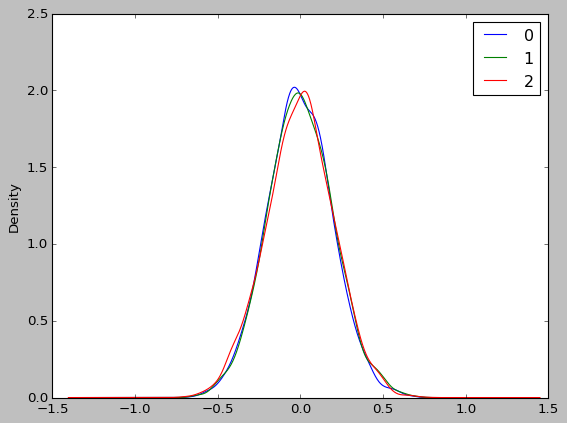

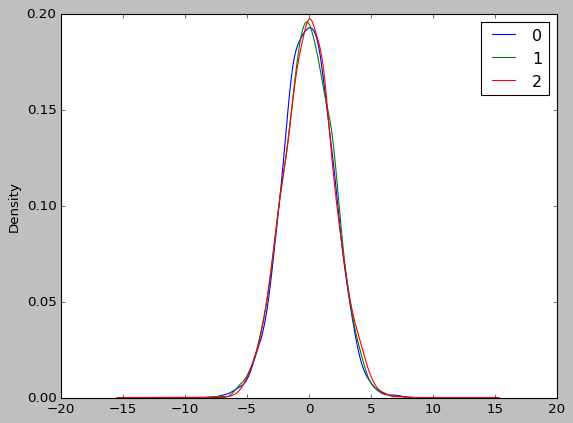

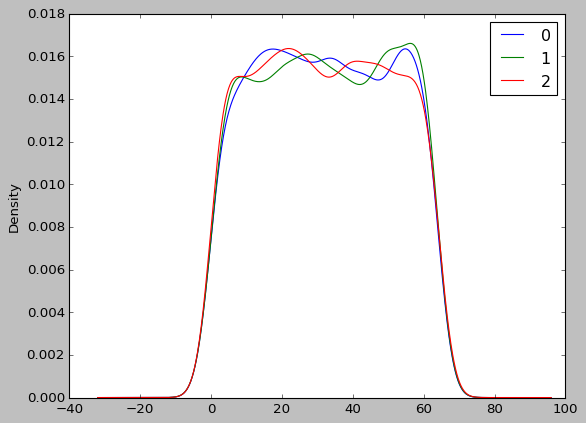

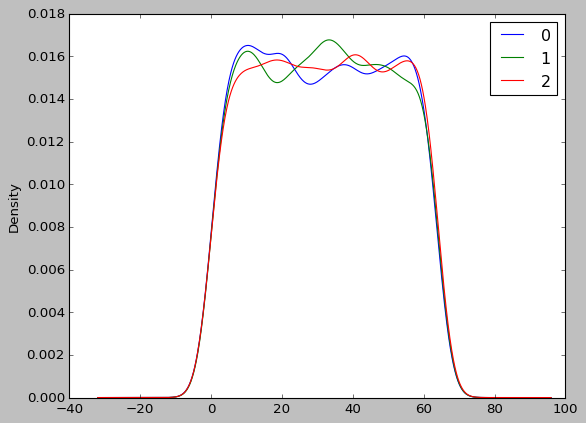

In [128]:
# Arreglos de Posiciones de electrones
x_BC = np.zeros([Np, dim])  # BC: Boundary condition position
x_act = np.zeros([Np, dim]) # act: actual (esta se usa para las condiciones iniciales)
x_new = np.zeros([Np, dim]) # new: nueva
# Arreglos de Velocidades
v_act = np.zeros([Np, dim])
v_new = np.zeros([Np, dim])

# Arreglos de Posiciones de iones
x_BC_i  = np.zeros([Np, dim])  # BC: Boundary condition position
x_act_i = np.zeros([Np, dim]) # act: actual (esta se usa para las condiciones iniciales)
x_new_i = np.zeros([Np, dim]) # new: nueva
# Arreglos de Velocidades
v_act_i = np.zeros([Np, dim])
v_new_i = np.zeros([Np, dim])
iz, d = 0, 0

# Ciclo para llenar posiciones y velocidades iniciales de los electrones y iones
for i in range(Np):
  # Posiciones en distribución uniforme de los iones y electrones
  x_act[i, 0]   = random.uniform(Xmin, Xmax)
  x_act[i, 1]   = random.uniform(Xmin, Xmax)
  x_act[i, 2]   = random.uniform(Xmin, Xmax)
  x_act_i[i, 0] = random.uniform(Xmin, Xmax)
  x_act_i[i, 1] = random.uniform(Xmin, Xmax)
  x_act_i[i, 2] = random.uniform(Xmin, Xmax)

  # Velocidades en distribución Gaussiana de los iones y electrones
  v_act_i[i, 0] = random.gauss(0, 2*vthi)
  v_act_i[i, 1] = random.gauss(0, 2*vthi)
  v_act_i[i, 2] = random.gauss(0, 2*vthi)
  v_act[i, 0]   = random.gauss(0, 2*vthe)
  v_act[i, 1]   = random.gauss(0, 2*vthe)
  v_act[i, 2]   = random.gauss(0, 2*vthe)

# Visualizar la distribución
velDfi = pd.DataFrame(v_act_i)
velDfe = pd.DataFrame(v_act)
velDfi.plot.density()
velDfe.plot.density()
# Visualizar la distribución
velDfi = pd.DataFrame(x_act_i)
velDfe = pd.DataFrame(x_act)
velDfi.plot.density()
velDfe.plot.density()

In [129]:
vthe

1.0

## Creación de arreglos

In [130]:
# crear malla
xx = np.linspace(Xmin, Xmax, Nx+1)
yy = np.linspace(Ymin, Ymax, Ny+1)
malla_x, malla_y = np.meshgrid(xx, yy)

energia_cinetica = np.zeros(n_iteraciones)
epsilon_r = np.zeros(n_iteraciones)

# campo electromagnetico (B & E on the nodes) y densidad de corriente
bx = np.zeros([Nx+1, Ny+1])
by = np.zeros([Nx+1, Ny+1])
bz = np.zeros([Nx+1, Ny+1])
ex = np.zeros([Nx+1, Ny+1])
ey = np.zeros([Nx+1, Ny+1])
ez = np.zeros([Nx+1, Ny+1])
jx = np.zeros([Nx+1, Ny+1])
jy = np.zeros([Nx+1, Ny+1])
jz = np.zeros([Nx+1, Ny+1])
divB = np.zeros([Nx+1, Ny+1])
divJ = np.zeros([Nx+1, Ny+1])

# Trabajo juan
bx_copy = np.zeros([Nx+1, Ny+1])
by_copy = np.zeros([Nx+1, Ny+1])
bz_copy = np.zeros([Nx+1, Ny+1])
ex_copy = np.zeros([Nx+1, Ny+1])
ey_copy = np.zeros([Nx+1, Ny+1])
ez_copy = np.zeros([Nx+1, Ny+1])

bx_tmp = np.zeros([Nx+1, Ny+1])
by_tmp = np.zeros([Nx+1, Ny+1])
bz_tmp = np.zeros([Nx+1, Ny+1])
ex_tmp = np.zeros([Nx+1, Ny+1])
ey_tmp = np.zeros([Nx+1, Ny+1])
ez_tmp = np.zeros([Nx+1, Ny+1])

#Malla de carga

ro = np.zeros([Nx+1,Ny+1])

# Definicion de los campos uniformes
for j in range(0,Ny+1):
  for i in range(0,Nx+1):
    ex[i,j] = 0
    bz[i,j] = 0.1
    
# Ciclo principal con campos uniformes!!!
t0 = 20
spread = 6

# Abrir archivos
df_energy_electrons = open('energy_electrons.txt','w')
df_energy_ions = open('energy_ions.txt','w')

## Ciclo PIC

In [131]:
i = 0 #Primera iteración

jx = np.zeros([Nx+1, Ny+1])
jy = np.zeros([Nx+1, Ny+1])

v_new[:,0],v_new[:,1],v_new[:,2] = v_act[:,0],v_act[:,1],v_act[:,2]
v_new_i[:,0],v_new_i[:,1],v_new_i[:,2] = v_act_i[:,0],v_act_i[:,1],v_act_i[:,2]
output_particle(x_act, v_act,i, 'electrones')
output_particle(x_act_i, v_act_i, i, 'iones')

# Primera iteración ELECTRONES
v_act = velocity(x_act,v_new,ex,ey,ez,bx,by,bz,-0.5*dt,q_e,m_e, Np) #v^{n-1/2}
v_new = velocity(x_act,v_act,ex,ey,ez,bx,by,bz,0.5*dt,q_e,m_e, Np) #v^{n+1/2}
x_new, x_BC = position(x_act,v_new,x_new,x_BC) #x^{n+1}
jx, jy = zig_zag(x_act, x_new, x_BC, jx, jy, partweight, q_e) #j^{n+1/2} REVISAR EL TIEMPO
# Primera iteración IONES
v_act_i = velocity(x_act_i,v_new_i,ex,ey,ez,bx,by,bz,-0.5*dt,q_i,m_i, Np) #v^{n-1/2}
v_new_i = velocity(x_act_i,v_act_i,ex,ey,ez,bx,by,bz,0.5*dt,q_i,m_i, Np) #v^{n+1/2}
x_new_i, x_BC_i = position(x_act_i,v_new_i,x_new_i,x_BC_i) #x^{n+1}
jx, jy = zig_zag(x_act_i, x_new_i, x_BC_i, jx, jy, partweight, q_i) #j^{n+1/2} REVISAR EL TIEMPO

# Guarda y avanza campos primera iteración
output_fields(ex,ey,ez,bx,by,bz,jx,jy,jz,i,divB)
bx,by,bz = FDTD_halftime(ex,ey,ez,bx,by,bz,-0.5*dt)

# input()

# Resto de iteraciones
for i in range(1, n_iteraciones):

    #PRUEBAS FDTD
    
    Atmp = 0.0 #np.exp(-0.5*((t0-i)/spread)**2)  # Pulso Gaussiano
    # ez[int(Nx/2),int(Ny/2)]=np.sin(i/5) # Pulso Gaussiano
    #ex[int(Nx/2),int(Ny/2)]=np.exp(-i**2/20) #Superluminal waves from a source that turns on immediately.
    # ez[int(Nx/2),int(Ny/2)]=np.sin(i/5)

    # GUARDAR ENERGÍAS
    if(i % n_check == 0): # Cada n_check iteraciones guarda energias
        print('se guarda energias en iteracion', i)
        energia_cinetica_electrones = energy(v_act)
        energia_cinetica_iones      = energy(v_act_i)

        df_energy_electrons.write(str(i))
        df_energy_electrons.write('\t')
        df_energy_electrons.write(str(energia_cinetica))
        df_energy_electrons.write('\n')

        df_energy_ions.write(str(i))
        df_energy_ions.write('\t')
        df_energy_ions.write(str(energia_cinetica))
        df_energy_ions.write('\n')

    # CICLO PRINCIPAL
    # Divergencia del campo magnético
    divB=divFt(bx,by,bz,divB)

    # Advance Electric and Magnetic field,
    # E advance like: E^{n} to E^{n+1}; B advance like: B^{n-1/2} to B^{n+1/2}
    ex,ey,ez,bx,by,bz,ex_copy,ey_copy,ez_copy,bx_copy,by_copy,bz_copy = FDTD(ex, ey, ez,
                                                                             bx, by, bz,
                                                                             jx, jy, jz,
                                                                             ex_copy, ey_copy, ez_copy,
                                                                             bx_copy, by_copy, bz_copy) 
    # Velocity of ions and electrons from v^{n-1/2} to v^{n+1/2}
    ex_copy, ey_copy, ez_copy, bx_copy, by_copy, bz_copy = interc_to_nodes(ex_copy, ey_copy, ez_copy,
                                                                           bx_copy, by_copy, bz_copy,
                                                                           ex_copy, ey_copy, ez_copy,
                                                                           bx_copy, by_copy, bz_copy)
    v_new = velocity(x_act, v_act,
                     ex_copy, ey_copy, ez_copy,
                     bx_copy, by_copy, bz_copy,
                     dt,q_e,m_e, Np) # Electrons
    v_new_i = velocity(x_act_i,v_act_i,ex_copy,
                       ey_copy, ez_copy,
                       bx_copy, by_copy, bz_copy,
                       dt, q_i, m_i, Np) # Ions
    
    #Position of electrons and ions from x^{n} to x^{n+1}
    x_new, x_BC = position(x_act,v_new,x_new,x_BC) 
    x_new_i, x_BC_i = position(x_act_i, v_new_i, x_new_i, x_BC_i) 
    
    # Densidad de corriente
    jx = np.zeros([Nx+1, Ny+1])
    jy = np.zeros([Nx+1, Ny+1])
    # Aporte Densidad de corriente IONES -> Sobrescribe la de los electrones
    jx, jy = zig_zag(x_act, x_new, x_BC, jx, jy, partweight, q_e)
    jx, jy = zig_zag(x_act_i, x_new_i, x_BC_i, jx, jy, partweight, q_i)

    #Calculo de la divergencia de la densidad de corriente 
    divJ = divFt(jx,jy,0,divJ)

    # Ecuación de continuidad
    if i%2 == 0:
      ro_actual = ro.copy()
      partial_ro = (ro_actual - ro_anterior)/dt
      ec_continuidad = partial_ro + divJ
      # print(ec_continuidad)
    else: ro_anterior = ro.copy()

    # print(divJ.shape)
    # print(ro.shape)

    # array[20, 20](cantidad1) + int(cantidad2) = aprox(0)
    


    # Asignar ELECTRONES antes de empezar el nuevo ciclo
    x_act[:,0],x_act[:,1],x_act[:,2] = x_BC[:,0],x_BC[:,1],x_BC[:,2]
    v_act[:,0],v_act[:,1],v_act[:,2] = v_new[:,0],v_new[:,1],v_new[:,2]
    # Asignar IONES antes de empezar el nuevo ciclo
    x_act_i[:,0], x_act_i[:,1], x_act_i[:,2] = x_BC_i[:,0], x_BC_i[:,1], x_BC_i[:,2]
    v_act_i[:,0], v_act_i[:,1], v_act_i[:,2] = v_new_i[:,0], v_new_i[:,1], v_new_i[:,2]



    # GUARDADO DE PARTÍCULAS Y CAMPOS
    if(i%n_check == 0): #Cada n_out iterations se guardan particle y campos
      #atrasa la velocidad para guardarla (la devuleve hasta tiempo {n})
      ex_copy, ey_copy, ez_copy, bx_copy, by_copy, bz_copy = interc_to_nodes(ex, ey, ez, bx, by, bz, ex_copy, ey_copy, ez_copy, bx_copy, by_copy, bz_copy)
      tmp_v_new_electrons = velocity(x_act, v_act, ex_copy, ey_copy, ez_copy, bx_copy, by_copy, bz_copy,-0.5*dt, q_e, m_e, Np) 
      tmp_v_new_ions      = velocity(x_act_i, v_act_i, ex_copy, ey_copy, ez_copy, bx_copy, by_copy, bz_copy,-0.5*dt, q_i, m_i, Np) 
      output_particle(x_act, tmp_v_new_electrons, i, 'electrones') # guarda electrones en tiempo {n}
      output_particle(x_act, tmp_v_new_ions, i, 'iones') # guarda IONES en tiempo {n}
      output_fields(ex_copy, ey_copy, ez_copy, bx_copy, by_copy, bz_copy,jx,jy,jz,i,divB)
      ex_tmp, ey_tmp, ez_tmp, bx_tmp, by_tmp, bz_tmp = interc_to_nodes(ex_copy, ey_copy, ez_copy, bx_copy,by_copy,bz_copy,ex_tmp, ey_tmp, ez_tmp, bx_tmp, by_tmp, bz_tmp)
      output_fields(ex_tmp,ey_tmp,ez_tmp,bx_tmp,by_tmp,bz_tmp,jx,jy,jz,i,divB,'fields_nodes')

df_energy_electrons.close()
df_energy_ions.close()

se guarda energias en iteracion 1
se guarda energias en iteracion 2
se guarda energias en iteracion 3
se guarda energias en iteracion 4
se guarda energias en iteracion 5
se guarda energias en iteracion 6
se guarda energias en iteracion 7
se guarda energias en iteracion 8
se guarda energias en iteracion 9
se guarda energias en iteracion 10
se guarda energias en iteracion 11
se guarda energias en iteracion 12
se guarda energias en iteracion 13
se guarda energias en iteracion 14
se guarda energias en iteracion 15
se guarda energias en iteracion 16
se guarda energias en iteracion 17
se guarda energias en iteracion 18
se guarda energias en iteracion 19
se guarda energias en iteracion 20
se guarda energias en iteracion 21
se guarda energias en iteracion 22
se guarda energias en iteracion 23
se guarda energias en iteracion 24
se guarda energias en iteracion 25
se guarda energias en iteracion 26
se guarda energias en iteracion 27
se guarda energias en iteracion 28
se guarda energias en iteraci

# Resultados

In [145]:
i = 0

5
iones0.pkl
x     5.663346
y    32.926542
z    52.082895
Name: 5, dtype: float64
iones1.pkl
x     7.628794
y     3.096587
z    18.375957
Name: 5, dtype: float64
iones2.pkl
x     7.468559
y     3.196185
z    18.376425
Name: 5, dtype: float64
iones3.pkl
x     7.305910
y     3.291789
z    18.376893
Name: 5, dtype: float64
iones4.pkl
x     7.140945
y     3.383340
z    18.377361
Name: 5, dtype: float64
iones5.pkl
x     6.973765
y     3.470781
z    18.377829
Name: 5, dtype: float64


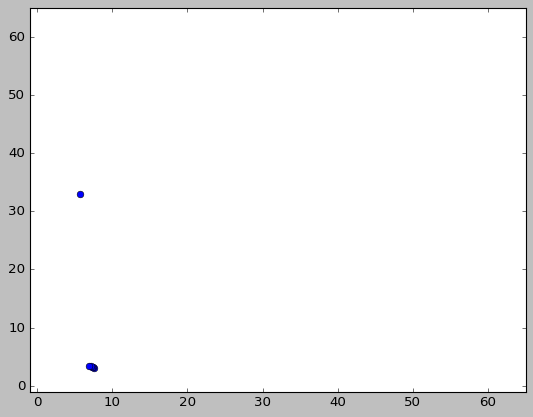

<Figure size 640x480 with 0 Axes>

In [152]:
plt.figure(1)
graficar_particula('iones', 5,'bo', i)
plt.figure(2)
# graficar_particula('electrones', 2500,'go', i)
i+=1

fields0.pkl
0.0
10


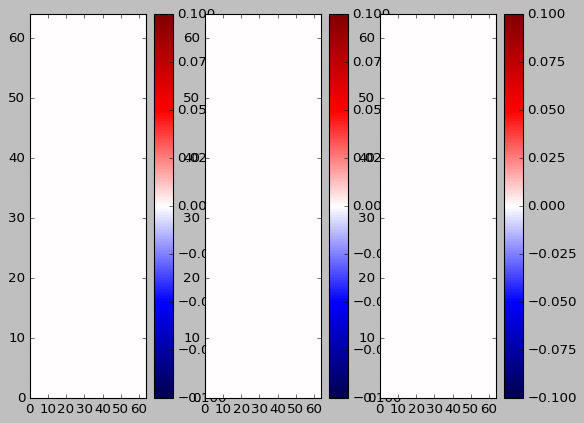

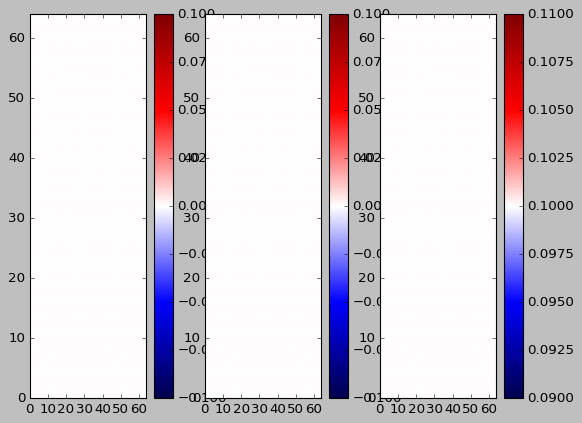

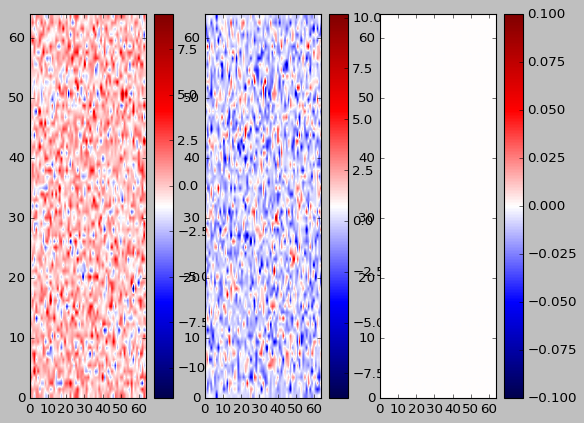

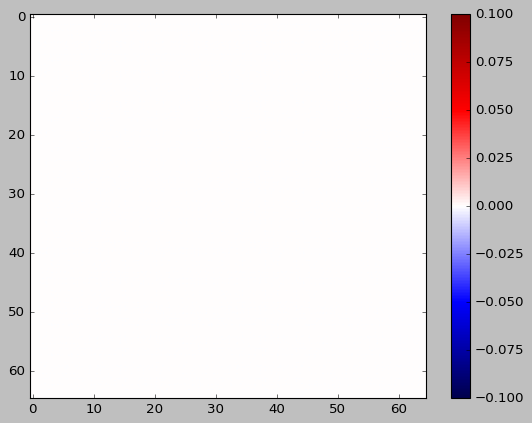

In [134]:
plt.style.use('classic')

i=0
file_name = 'fields'+ str(i) +'.pkl'
df = pd.read_pickle(file_name)
print(file_name)
ex_tmp =  np.reshape(np.array(df['ex']),[Nx+1,Ny+1],order ='F')
ey_tmp =  np.reshape(np.array(df['ey']),[Nx+1,Ny+1], order ='F')
ez_tmp =  np.reshape(np.array(df['ez']),[Nx+1,Ny+1],order ='F')
bx_tmp =  np.reshape(np.array(df['bx']),[Nx+1,Ny+1],order ='F')
by_tmp =  np.reshape(np.array(df['by']),[Nx+1,Ny+1],order ='F')
bz_tmp =  np.reshape(np.array(df['bz']),[Nx+1,Ny+1],order ='F')
jx_tmp =  np.reshape(np.array(df['jx']),[Nx+1,Ny+1],order ='F')
jy_tmp =  np.reshape(np.array(df['jy']),[Nx+1,Ny+1],order ='F')
jz_tmp =  np.reshape(np.array(df['jz']),[Nx+1,Ny+1],order ='F')
divB_tmp = np.reshape(np.array(df['DivB']),[Nx+1,Ny+1],order ='F')


plt.figure(1);plt.clf()
plt.subplot(1,3,1)
plt.imshow(ex_tmp.T,extent=[Xmin,Xmax,Ymin,Ymax],aspect='auto', cmap='seismic');plt.colorbar()
plt.subplot(1,3,2)
plt.imshow(ey_tmp.T,extent=[Xmin,Xmax,Ymin,Ymax],aspect='auto', cmap='seismic');plt.colorbar()
plt.subplot(1,3,3)
plt.imshow(ez_tmp.T,extent=[Xmin,Xmax,Ymin,Ymax],aspect='auto', cmap='seismic');plt.colorbar()

plt.figure(2);plt.clf()
plt.subplot(1,3,1)
plt.imshow(bx_tmp.T,extent=[Xmin,Xmax,Ymin,Ymax],aspect='auto', cmap='seismic');plt.colorbar()
plt.subplot(1,3,2)
plt.imshow(by_tmp.T,extent=[Xmin,Xmax,Ymin,Ymax],aspect='auto', cmap='seismic');plt.colorbar()
plt.subplot(1,3,3)
plt.imshow(bz_tmp.T,extent=[Xmin,Xmax,Ymin,Ymax],aspect='auto', cmap='seismic');plt.colorbar()

plt.figure(4);plt.clf()
plt.subplot(1,3,1)
plt.imshow(jx_tmp.T,extent=[Xmin,Xmax,Ymin,Ymax],aspect='auto', cmap='seismic');plt.colorbar()
plt.subplot(1,3,2)
plt.imshow(jy_tmp.T,extent=[Xmin,Xmax,Ymin,Ymax],aspect='auto', cmap='seismic');plt.colorbar()
plt.subplot(1,3,3)
plt.imshow(jz_tmp.T,extent=[Xmin,Xmax,Ymin,Ymax],aspect='auto', cmap='seismic');plt.colorbar()

plt.figure();plt.clf()
plt.imshow(divB_tmp,aspect='auto',cmap='seismic');plt.colorbar()
print(np.sqrt(np.mean(divB_tmp**2)))
i=i+10;print(i)

In [135]:
np.sqrt(np.mean(jx_tmp**2))

1.7511503559493813

In [136]:
np.shape(jx_tmp)

(65, 65)